In [1]:
from PIL import *
import numpy as np
import cv2
from cv2 import *
from scipy.ndimage import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.hub
import os
from torchvision.datasets import *
import random
import torch.utils.data as Data
import tensorboard as tb
import tensorboardX as tbx


from utility.output import *

In [2]:
DATA_ROOT = r'D:\onedrive\eyisheng\OneDrive\files\大三下\科研\金属分类\data'
DATA_ROOT_CORROSION = DATA_ROOT + r'\corrosion'
DATA_ROOT_NONCORROSION = DATA_ROOT + r'\noncorrosion'

DATASET_ROOT = './dataset'
DATASET_ROOT_TRAIN = os.path.join(DATASET_ROOT,'train')
DATASET_ROOT_TEST = os.path.join(DATASET_ROOT,'test')
DATASET_TRAIN_POS = os.path.join(DATASET_ROOT_TRAIN,'1')
DATASET_TRAIN_NEG = os.path.join(DATASET_ROOT_TRAIN,'0')
DATASET_TEST_POS = os.path.join(DATASET_ROOT_TEST,'1')
DATASET_TEST_NEG = os.path.join(DATASET_ROOT_TEST,'0')

if not os.path.exists(DATASET_ROOT_TRAIN):
    os.mkdir(DATASET_ROOT_TRAIN)

if not os.path.exists(DATASET_ROOT_TEST):
    os.mkdir(DATASET_ROOT_TEST)

#### 模型保存文件路径
MODEL_SAVE_PATH = './model'
#### 数据路径
DATA_PATH = r'E:\buffer\dataset\train'

#### 模型保存
def checkpoint(net,model='se_resnet20'):
    # 保存和加载整个模型  
    torch.save(net, os.path.join(MODEL_SAVE_PATH,model+'_model.pth'))  
    # 仅保存和加载模型参数  
    torch.save(net.state_dict(), os.path.join(MODEL_SAVE_PATH,model+'_params.pth')) 
    return

#### 模型恢复
def modelrestore(model='se_resnet20'):
    model = None
    if os.path.exists(os.path.join(MODEL_SAVE_PATH,model+'_model.pth')):
        model = torch.load(os.path.join(MODEL_SAVE_PATH,model+'_model.pth'))
        if os.path.exists(os.path.join(MODEL_SAVE_PATH,model+'_params.pth')):
            model.load_state_dict(os.path.join(MODEL_SAVE_PATH,model+'_params.pth')) 
    return model

In [ ]:
#### get raw jpg files from directories
def getFileNames(is_corrosion=False):
    path_files = []
    walk_root = DATA_ROOT_NONCORROSION if is_corrosion==False else DATA_ROOT_CORROSION
    
    for root, dirs, files in os.walk(walk_root):
        for f in files:
            fpath = os.path.join(root,f)
            path_files.append(fpath)
            
    label = 0 if is_corrosion==False else 1
    res = list(map(lambda x:(x,label),path_files))
    return res


def checkImgShape():
    shapes = set()
    for line in non_corrosion_files:
        jpgfile = Image.open(line[0])
        jpgfile = np.array(jpgfile)
        shapes.add(jpgfile.shape)
    return shapes


def resizeImg(src,dsize):
    jpgfile = Image.open(src)
    jpgfile = np.array(jpgfile)
    jpgfile = cv2.resize(jpgfile,dsize)
    return jpgfile


def preprocessingPipeline(src,target):
    img = resizeImg(src,(256,256)) ### image shapes
    return [src,target,img]
    
    
def filesToImg(path_files):
    train = []
    test = []
    for line in path_files:
        if random.random()<0: ### train test split
            test.append( preprocessingPipeline(line[0],line[1]) )
        else:
            train.append( preprocessingPipeline(line[0],line[1]) )
    return {'train':train,'test':test}
    
    
def saveImgToFiles(imgs):
    
    if not os.path.exists(DATASET_TRAIN_POS):
        os.mkdir(DATASET_TRAIN_POS)
    if not os.path.exists(DATASET_TRAIN_NEG):
        os.mkdir(DATASET_TRAIN_NEG) 
    if not os.path.exists(DATASET_TEST_POS):
        os.mkdir(DATASET_TEST_POS)
    if not os.path.exists(DATASET_TEST_NEG):
        os.mkdir(DATASET_TEST_NEG)
        
    for line in imgs['train']:
        src = os.path.split(line[0])[-1]
        if line[1]==0:
            src = os.path.join(DATASET_TRAIN_NEG,src)
        elif line[1]==1:
            src = os.path.join(DATASET_TRAIN_POS,src)
        Image.fromarray(line[2]).save(src)
        
    for line in imgs['test']:
        src = os.path.split(line[0])[-1]
        if line[1]==0:
            src = os.path.join(DATASET_TEST_NEG,src)
        elif line[1]==1:
            src = os.path.join(DATASET_TEST_POS,src)
        Image.fromarray(line[2]).save(src)
    return

In [18]:
def ImgWriter():
    img_data = filesToImg(img_files)

    saveImgToFiles(img_data)
    return


# jpgfile = Image.open(os.path.join(DATA_PATH,r'2\LY01-N1074.jpg'))
# jpgfile = np.array(jpgfile)
# jpgfile.shape

(256, 256, 3)

In [8]:
EPOCH = 20
BATCH_SIZE = 6
NUM_CLASS = 4
CV = 5

P_momentem = 0.8
P_lr = 1e-3
train_ratio = 0.8 

In [5]:
#### image transformation
data_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])
])

full_dataset = ImageFolder(DATA_PATH,transform = data_transform)

total_size = len(full_dataset)
train_size = int(np.floor( total_size * train_ratio ))
test_size = int(total_size - train_size)


In [9]:
hub_model = torch.hub.load(
    'moskomule/senet.pytorch',
    'se_resnet20',
    num_classes=NUM_CLASS,
)
net = hub_model

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=P_lr)

Using cache found in C:\Users\steve/.cache\torch\hub\moskomule_senet.pytorch_master


In [10]:
_total_loss = []
_total_acc = []
_metrics = []

for cv in range(CV):
    
    print('DEBUG:: fold ',cv)
    
    #### load model
    hub_model = torch.hub.load(
        'moskomule/senet.pytorch',
        'se_resnet20',
        num_classes=NUM_CLASS,
    )
    net = hub_model

    #### use CUDA if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    
    #### define criterian & optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=P_lr)
    
    #### data splitting
    dataset_train, dataset_test = torch.utils.data.random_split(full_dataset, [train_size,test_size])
    trainloader = Data.DataLoader(dataset=dataset_train, batch_size=BATCH_SIZE, shuffle=True)
    testloader = Data.DataLoader(dataset=dataset_test, batch_size=BATCH_SIZE, shuffle=True)
    
    #### training
    _loss = []
    __record_train_num = 0
    for epoch in range(EPOCH):  # loop over the dataset multiple times
        
        print('DEBUG:: training epoch ',epoch)
        
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            #### get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            #### zero the parameter gradients
            optimizer.zero_grad()
            #### forward + backward + optimize
            outputs = net(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            #### print statistics
            running_loss += loss.item()
            _loss.append(running_loss)
            
            __record_train_num += len(labels)
            print('DEBUG:: num has trained',__record_train_num)

    print('DEBUG:: Finished Training')

    
    #### predicting
    class_correct = list(0. for i in range(NUM_CLASS))
    class_total = list(0. for i in range(NUM_CLASS))
    Ypred = []
    Ytest = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            Ytest.extend(labels.tolist())
            Ypred.extend(predicted.tolist())
    
    _metrics.append(computeMetrics(Ypred,Ytest))
    
    _total_loss.append(_loss)
    


Using cache found in C:\Users\steve/.cache\torch\hub\moskomule_senet.pytorch_master


training epoch::  0
DEBUG:: num has trained 6
DEBUG:: num has trained 12
DEBUG:: num has trained 18
DEBUG:: num has trained 24
DEBUG:: num has trained 30
DEBUG:: num has trained 36
DEBUG:: num has trained 42
DEBUG:: num has trained 48
DEBUG:: num has trained 54
DEBUG:: num has trained 60
DEBUG:: num has trained 66
DEBUG:: num has trained 72
DEBUG:: num has trained 78
DEBUG:: num has trained 84
DEBUG:: num has trained 90
DEBUG:: num has trained 96
DEBUG:: num has trained 102
DEBUG:: num has trained 108
DEBUG:: num has trained 114
DEBUG:: num has trained 120
DEBUG:: num has trained 126
DEBUG:: num has trained 132
DEBUG:: num has trained 138
DEBUG:: num has trained 144


KeyboardInterrupt: 

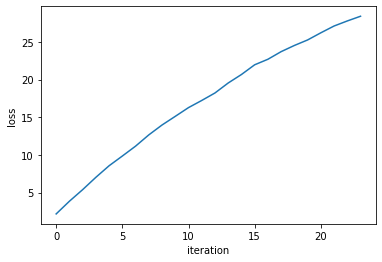

In [15]:
plt.figure()
plt.xlabel('iteration')
plt.ylabel('loss')
plt.plot(_total_loss)

[]